# Semi-supervised AQI Classification — Self-Training

- Mục tiêu: chạy self-training để **tăng lượng nhãn** cho AQI khi thiếu nhãn.
- Output: metrics JSON + sample predictions + sample alerts.
- Mini project: sweep TAU / LABEL_MISSING_FRACTION và so sánh với baseline supervised.

In [1]:
SEMI_DATASET_PATH = "data/processed/dataset_for_semi.parquet"
CUTOFF = "2017-01-01"

TAU = 0.90
MAX_ITER = 10
MIN_NEW_PER_ITER = 20
VAL_FRAC = 0.20
RANDOM_STATE = 42

METRICS_PATH = "data/processed/metrics_self_training.json"
PRED_SAMPLE_PATH = "data/processed/predictions_self_training_sample.csv"
ALERTS_SAMPLE_PATH = "data/processed/alerts_self_training_sample.csv"
ALERT_FROM_CLASS = "Unhealthy"

In [2]:
# Parameters
SEMI_DATASET_PATH = "data/processed/dataset_for_semi.parquet"
CUTOFF = "2017-01-01"
TAU = 0.9
MAX_ITER = 10
MIN_NEW_PER_ITER = 20
VAL_FRAC = 0.2
RANDOM_STATE = 42
METRICS_PATH = "data/processed/metrics_self_training.json"
PRED_SAMPLE_PATH = "data/processed/predictions_self_training_sample.csv"
ALERTS_SAMPLE_PATH = "data/processed/alerts_self_training_sample.csv"
ALERT_FROM_CLASS = "Unhealthy"


,iter,val_accuracy,val_f1_macro,unlabeled_pool,new_pseudo,tau
0,1,0.722615,0.679270,383962,76134,0.9
1,2,0.713781,0.678319,307828,202713,0.9
2,3,0.706461,0.672945,105115,45622,0.9
3,4,0.700151,0.665001,59493,12716,0.9
4,5,0.695356,0.655768,46777,5519,0.9
5,6,0.670116,0.624643,41258,1660,0.9
6,7,0.690056,0.650048,39598,2953,0.9
7,8,0.663806,0.612969,36645,587,0.9
8,9,0.701161,0.664477,36058,1762,0.9
9,10,0.666835,0.617609,34296,353,0.9


Test accuracy: 0.589046847819567
Test f1_macro: 0.5343258092284096


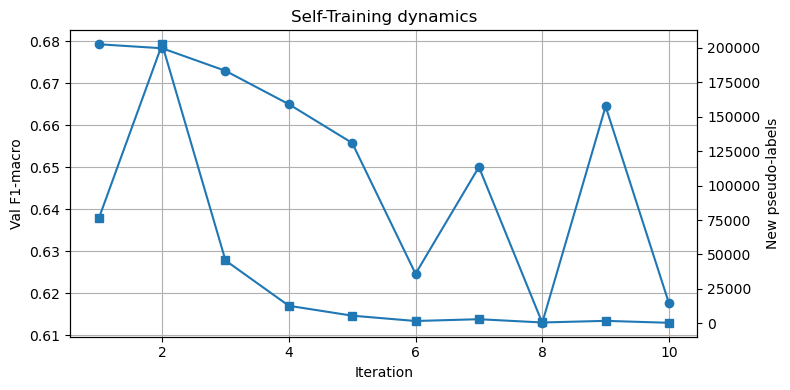

Saved: C:\Code\DataMining\air_guard\data\processed\metrics_self_training.json
Saved: C:\Code\DataMining\air_guard\data\processed\predictions_self_training_sample.csv
Saved: C:\Code\DataMining\air_guard\data\processed\alerts_self_training_sample.csv


In [3]:
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt

from src.semi_supervised_library import (
    SemiDataConfig, SelfTrainingConfig, run_self_training, add_alert_columns
)

PROJECT_ROOT = Path(".").resolve()
if not (PROJECT_ROOT / "data").exists() and (PROJECT_ROOT.parent / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent.resolve()
df = pd.read_parquet((PROJECT_ROOT / SEMI_DATASET_PATH).resolve())

data_cfg = SemiDataConfig(cutoff=CUTOFF, random_state=int(RANDOM_STATE))
st_cfg = SelfTrainingConfig(
    tau=float(TAU),
    max_iter=int(MAX_ITER),
    min_new_per_iter=int(MIN_NEW_PER_ITER),
    val_frac=float(VAL_FRAC),
)

out = run_self_training(df, data_cfg, st_cfg)
history = pd.DataFrame(out["history"])
pred_df = out["pred_df"]
test_metrics = out["test_metrics"]

display(history)
print("Test accuracy:", test_metrics["accuracy"])
print("Test f1_macro:", test_metrics["f1_macro"])

# Plot dynamics
fig, ax1 = plt.subplots(figsize=(8, 4))
ax1.plot(history["iter"], history["val_f1_macro"], marker="o")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Val F1-macro")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(history["iter"], history["new_pseudo"], marker="s")
ax2.set_ylabel("New pseudo-labels")
plt.title("Self-Training dynamics")
plt.tight_layout()
plt.show()

# Save artifacts
metrics_path = (PROJECT_ROOT / METRICS_PATH).resolve()
pred_path = (PROJECT_ROOT / PRED_SAMPLE_PATH).resolve()
alerts_path = (PROJECT_ROOT / ALERTS_SAMPLE_PATH).resolve()
for p in [metrics_path, pred_path, alerts_path]:
    p.parent.mkdir(parents=True, exist_ok=True)

payload = {
    "method": "self_training",
    "data_cfg": data_cfg.__dict__,
    "st_cfg": st_cfg.__dict__,
    "history": out["history"],
    "test_metrics": test_metrics,
    "model_info": out["model_info"],
}
with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump(payload, f, ensure_ascii=False, indent=2)

pred_df.head(5000).to_csv(pred_path, index=False)
alerts = add_alert_columns(pred_df, pred_col="y_pred", severe_from=ALERT_FROM_CLASS)
alerts.head(5000).to_csv(alerts_path, index=False)

print("Saved:", metrics_path)
print("Saved:", pred_path)
print("Saved:", alerts_path)